In [ ]:
# It's a good idea to ensure you're running the latest version of any libraries you need .
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
!pip install -Uqq fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 51.2 MB/s eta 0:00:00


In [ ]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        # generator which yields dicts with:
        # {'title','image','thumbnail','url','height','width','source'}
        search_results = ddgs.images(keywords=term)
        # grap number of max_images urls
        image_urls = [result.get("image") for result in search_results[:max_images]]
        # convert to L (functionally extended list class from fastai)
        return L(image_urls)

# example usage:
urls = search_images("dog images", max_images=10)
print(urls[0])

Searching for 'dog images'
https://wallpapercave.com/wp/wp9015508.jpg


In [ ]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('infected plant image', max_images=1)
urls[0]

Searching for 'infected plant image'


'https://c8.alamy.com/comp/BNE1C4/close-up-of-a-leaf-infected-with-plant-virus-BNE1C4.jpg'

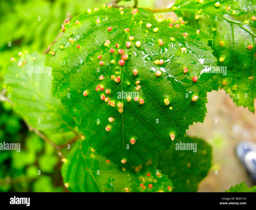

In [ ]:
from fastdownload import download_url
dest = 'infected_plant.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'healthy plant image'


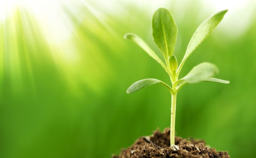

In [ ]:
urls = search_images('healthy plant image', max_images=1)
dest = 'healthy_plant2.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [ ]:
searches = 'infected plant','healthy plant'
path = Path('healthy_plant_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} leaves photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} side photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'infected plant photo'
Searching for 'infected plant leaves photo'
Searching for 'infected plant side photo'
Searching for 'healthy plant photo'
Searching for 'healthy plant leaves photo'
Searching for 'healthy plant side photo'


In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

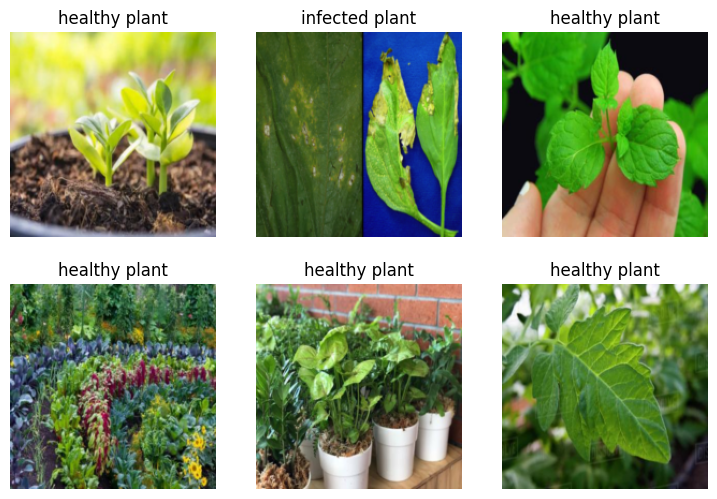

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 54.7MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.326268,0.461188,0.235294,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.421816,0.347064,0.147059,00:29
1,0.283173,0.339397,0.088235,00:29
2,0.236518,0.292794,0.058824,00:30


In [ ]:
is_infected,_,probs = learn.predict('infected_plant.jpg')
print(f"This is: {is_infected}.")
print(f"Probability it's an healthy plant: {probs[0]:.4f}")

This is: infected plant.
Probability it's an healthy plant: 0.0004
